# Using `torch.nn` to construct neural networks

A Typical training procedure for a neural network is as follows:
1. Define the neural network that has some learnable parameters(or weights)
2. Iterate over a dataset of inputs
3. Process input through the network
4. Compute the loss (how far is the output from being correct)
5. Propagate gradients back into the network's parameters
6. Update the weights of the network, typically using a simple update rule: `weight = weight - learning_rate * gradient`

## Define the network

You just have to define the `forward` function, and the `backward` function (where gradients are computed) is automatically defined for you using `autograd`. You can use any of the Tensor operations in the `forward` function.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

  def __init__(self):
    super(Net, self).__init__()
    # 1 input image channel, 6 output channels, 5x5 square convolution
    # kernel
    self.conv1 = nn.Conv2d(1, 6, 5)
    self.conv2 = nn.Conv2d(6, 16, 5)
    # an affine operation: y = Wx + b
    self.fc1 = nn.Linear(16 * 5 * 5, 120) # 5*5 from image dimension
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, input):
    # Convolution layer C1: 1 input image channel, 6 output channels,
    # 5x5 square convolution, it use RELU activation function, and
    # outputs a Tensor with size (N, 6, 28, 28), where N is the size of the batch

    c1 = F.relu(self.conv1(input))
    # Subsampling layer S2: 2x2 grid, purely functional,
    # this layer does not have any parameter, and outputs a (N, 6, 14, 14) Tensor
    s2 = F.max_pool2d(c1, (2, 2))
    # Convolution layer C3: 6 input channels, 16 output channels,
    # 5x5 square convplution, it uses RELU activation function, and
    # outputs a (N, 16, 10, 10) Tensor
    c3 = F.relu(self.conv2(s2))
    # Subsampleing layer S4: 2x2 grid, purely functional,
    # this layer does not have any parameter, and outputs a (N, 16, 5, 5) Tensor
    s4 = F.max_pool2d(c3, 2)
    # Flatten operation: purely functional, outputs a (N, 400) Tensor
    s4 = torch.flatten(s4, 1)
    # Fully connected layer F5: (N, 400) Tensor input,
    # and outputs a (N, 120) Tensor, it uses RELU activation function
    f5 = F.relu(self.fc1(s4))
    # Fully connected layer F6: (N, 120) Tensor input,
    # and outputs a (N, 120) Tensor, it uses RELU activation function
    f6 = F.relu(self.fc2(f5))
    # Gaussian layer output: (N, 84) Tensor input, and
    # outputs a (N, 10) Tensor
    output = self.fc3(f6)
    return output

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


The learnable parameters of a model are returned by `net.parameters`

In [2]:
params = list(net.parameters())
print(len(params))
print(params[0].size()) # conv1's .weight

10
torch.Size([6, 1, 5, 5])


In [3]:
input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out)

tensor([[-0.0507, -0.0698,  0.0784,  0.1600, -0.0455, -0.0069,  0.0630, -0.0839,
         -0.0016, -0.0558]], grad_fn=<AddmmBackward0>)


Zero the gradient buffers of all parameters and backprops with random gradients:

In [4]:
net.zero_grad()
out.backward(torch.randn(1, 10))

**Recap**
- `torch.Tensor` - A *multi-dimensional array* with support for autograd operations like `backward()`. Also *holds the gradient* w.r.t the tensor.
- `nn.Module` - Neural network module. *Cpnvenient way of encapsulating parameters*, with helpers for moving them to GPU, exporting, loading, etc.
- `nn.Parameter` - A kind of Tensor, that is *automatically registered as a parameter when assigned as an attribute to a* `Module`.
- `autograd.Function` - Implements *forward and backward definitions of an autograd operation*. Every `Tensor` operation creates at least a single `Function` node that connects to functions that created a `Tensor` and *encodes its history*.

**At this point, we coverd:**
- Defining a neural network
- Processing inputs and calling backward

**Still Left**
- Computing the loss
- Updating the weights of the network

## Loss Function

A loss function takes the (output, target) pair of inputs, and computes a value that estimates how far away the output is from the target.

There are several different loss functions under nn package. A simple loss is: `nn.MSELoss` which computes the mean-squared error between the output and the target.

For example:

In [5]:
output = net(input)
target = torch.randn(10) # a dummy target, for example
target = target.view(1, -1) # make it the same shape as output
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

tensor(0.3494, grad_fn=<MseLossBackward0>)


In [6]:
print(loss.grad_fn) # MSELoss
print(loss.grad_fn.next_functions[0][0]) # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0]) # ReLU

## Backprop

To backpropagate the error all we have to do is to `loss.backward()`. You need to clear the existing gradients though, else gradients will be accumulated to existing gradients.

In [7]:
net.zero_grad() # zeros the gradient buffers of all parameters
print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
None


Than we shall call `loss.backward()`, and have a look at conv1's bias gradients before and after the backward.

In [8]:
loss.backward()
print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad after backward
tensor([-0.0023,  0.0066, -0.0065,  0.0119,  0.0027,  0.0041])


## Update the weights

The simplest update rule used in practice is the Stochastic Gradient Descent (SGD):

```text
weight = weight - learning_rate * gradient
```

We can implement this using simple Python code:
```Python
learning_rate = 0.01
for f in net.parameters():
  f.data.sub_(f.grad.data * learning_rate)
```

However, as you use neural networks, you want to use various different update rules such as SGD, Nesterov-SGD, Adam, RMSProp, etc. To enable this, we built a small package: `torch.optim` that implements all these methods. Using it is very simple:

In [9]:
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

# in your training loop:
optimizer.zero_grad() # zero the gradient buffers
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step() # Does the update

# Training a Classifier

## Training an image classifier

### Load and normalize CIFAR10

using `torchvision`

In [10]:
import torch
import torchvision
import torchvision.transforms as transforms

In [11]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
batch_size = 4
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:02<00:00, 69.9MB/s]


In [12]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

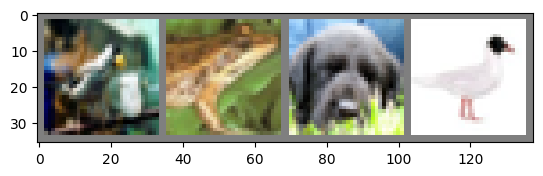

bird  frog  dog   bird 


In [13]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### Define a Convolutional Neural Network

In [14]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = torch.flatten(x, 1) # flatten all dimensions except batch
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

net = Net()

In [15]:
net

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

### Define a Loss function and optimizer

In [16]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Train the network

In [17]:
for epoch in range(2): # loop over the dataset multiple times

  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if i % 2000 == 1999: # print every 2000 mini-batches
      print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
      running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.242
[1,  4000] loss: 1.899
[1,  6000] loss: 1.710
[1,  8000] loss: 1.579
[1, 10000] loss: 1.512
[1, 12000] loss: 1.452
[2,  2000] loss: 1.402
[2,  4000] loss: 1.355
[2,  6000] loss: 1.366
[2,  8000] loss: 1.325
[2, 10000] loss: 1.298
[2, 12000] loss: 1.293
Finished Training


save the trained model:

In [18]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

### Test the network on the test data

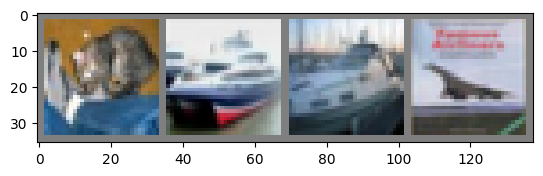

GroundTruth:  cat   ship  ship  plane


In [19]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [20]:
net = Net()
net.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

In [21]:
outputs = net(images)

In [22]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

Predicted:  cat   ship  ship  plane


In [23]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
  for data in testloader:
    images, labels = data
    # calculate outputs by running images through the network
    outputs = net(images)
    # the class with the highest energy is what we choose as prediction
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 53 %


In [24]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
  for data in testloader:
    images, labels = data
    outputs = net(images)
    _, predictions = torch.max(outputs, 1)
    # collect the correct predictions for each class
    for label, prediction in zip(labels, predictions):
      if label == prediction:
        correct_pred[classes[label]] += 1
      total_pred[classes[label]] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
  accuracy = 100 * float(correct_count) / total_pred[classname]
  print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')


Accuracy for class: plane is 51.5 %
Accuracy for class: car   is 58.6 %
Accuracy for class: bird  is 37.0 %
Accuracy for class: cat   is 29.0 %
Accuracy for class: deer  is 56.2 %
Accuracy for class: dog   is 44.4 %
Accuracy for class: frog  is 69.5 %
Accuracy for class: horse is 58.0 %
Accuracy for class: ship  is 79.9 %
Accuracy for class: truck is 50.7 %


In [25]:
import torch
import torch.onnx

In [26]:
model = Net()
model.load_state_dict(torch.load(PATH, map_location='cpu'))
model.eval()


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [27]:
!pip install onnx onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.8 MB/s eta 0:00:00


In [28]:
dummy_input = torch.randn(1, 3, 32, 32)

torch.onnx.export(
    model,
    dummy_input,
    'lenet.onnx',
    export_params=True,
    opset_version=11,
    do_constant_folding=True,
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}}
)

In [29]:
import onnx
onnx_model = onnx.load("lenet.onnx")
onnx.checker.check_model(onnx_model)

## Introduction to ONNX

[Open Neural Network eXchange(ONNX)](https://onnx.ai/) is an open standard format for representing machine learning models. The `torch.onnx` module provides APIs to capture the computation graph from a native PyTorch `torch.nn.Module` model and convert it into an [ONNX graph](https://github.com/onnx/onnx/blob/main/docs/IR.md).

In [30]:
!pip install --upgrade onnx onnxscript onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 705.4/705.4 kB 9.1 MB/s eta 0:00:00


In [31]:
import torch
print(torch.__version__)

import onnxscript
print(onnxscript.__version__)

import onnxruntime
print(onnxruntime.__version__)

2.6.0+cu124
0.2.4
1.21.0


### Install the required dependencies

In [33]:
!pip install --upgrade onnx onnxscript

### Author a simple image classifier model

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ImageClassifierModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 6, 5)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x : torch.Tensor):
    x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
    x = F.max_pool2d(F.relu(self.conv2(x)), 2)
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [37]:
model = ImageClassifierModel()
print(model)

ImageClassifierModel(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### Export the model to ONNX format